<a href="https://colab.research.google.com/github/cam2149/MachineLearningIV/blob/main/sources/AA-IV-2025-I-object-localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AA IV 2025-I: object localization

## Cargar el dataset de Kaggle

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
import numpy as np

from plotly.subplots import make_subplots
import math

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


In [ ]:
!pip install pycaret

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c child-mind-institute-problematic-internet-use

... resuming from 20971520 bytes (6646887275 bytes left) ...
100% 6.21G/6.21G [03:11<00:00, 39.1MB/s]
100% 6.21G/6.21G [03:11<00:00, 34.6MB/s]


In [ ]:
!unzip child-mind-institute-problematic-internet-use.zip

Archive:  child-mind-institute-problematic-internet-use.zip
  inflating: data_dictionary.csv     
  inflating: sample_submission.csv   
  inflating: series_test.parquet/id=00115b9f/part-0.parquet  
  inflating: series_test.parquet/id=001f3379/part-0.parquet  
  inflating: series_train.parquet/id=00115b9f/part-0.parquet  
  inflating: series_train.parquet/id=001f3379/part-0.parquet  
  inflating: series_train.parquet/id=00f332d1/part-0.parquet  
  inflating: series_train.parquet/id=01085eb3/part-0.parquet  
  inflating: series_train.parquet/id=012cadd8/part-0.parquet  
  inflating: series_train.parquet/id=012e3869/part-0.parquet  
  inflating: series_train.parquet/id=029a19c9/part-0.parquet  
  inflating: series_train.parquet/id=02cebf33/part-0.parquet  
  inflating: series_train.parquet/id=02cf7384/part-0.parquet  
  inflating: series_train.parquet/id=035c96dd/part-0.parquet  
  inflating: series_train.parquet/id=03a9019b/part-0.parquet  
  inflating: series_train.parquet/id=0417c91e/p

## Exploración del archivo series_train.parquet

In [ ]:
# Assuming 'series_test.parquet' is in the current directory or you provide the correct path
try:
    df_parquet = pd.read_parquet('series_train.parquet/id=001f3379')
    print(df_parquet.describe())
    print(df_parquet.info())
    print(df_parquet.shape)
except FileNotFoundError:
    print("Error: 'series_train.parquet' not found. Please make sure the file exists in the current directory or provide the correct path.")
except Exception as e:
    print(f"An error occurred: {e}")

               step              X              Y              Z  \
count  396396.00000  396396.000000  396396.000000  396396.000000   
mean   198197.50000      -0.004272       0.016859      -0.631731   
std    114429.81299       0.351582       0.303726       0.622458   
min         0.00000      -1.038711      -1.522690      -1.018787   
25%     99098.75000      -0.052803      -0.044517      -1.009344   
50%    198197.50000      -0.020622      -0.028179      -1.007728   
75%    297296.25000      -0.019081       0.020307      -0.294459   
max    396395.00000       1.034351       1.946303       1.146284   

                enmo         anglez  non-wear_flag          light  \
count  396396.000000  396396.000000  396396.000000  396396.000000   
mean        0.011926     -55.630768       0.655708      16.771982   
std         0.024306      50.368004       0.467727      95.304085   
min         0.000000     -88.761833       0.000000       0.000000   
25%         0.008622     -88.386049       

In [ ]:
df_parquet.shape

(396396, 13)

In [ ]:
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# Instead of using pq.ParquetFile, use ds.dataset to read the directory
dataset = ds.dataset('/content/series_train.parquet', format='parquet')

# Print the schema of the dataset
print(dataset.schema)

# Get the total number of files (row groups) in the Parquet dataset
num_files = len(list(dataset.get_fragments()))
print(f"Total number of files (row groups): {num_files}")

# Get the total number of rows
num_rows = sum(fragment.count_rows() for fragment in dataset.get_fragments())
print(f"Total number of rows: {num_rows}")

step: uint32
X: float
Y: float
Z: float
enmo: float
anglez: float
non-wear_flag: float
light: float
battery_voltage: float
time_of_day: int64
weekday: int8
quarter: int8
relative_date_PCIAT: float
Total number of files (row groups): 996
Total number of rows: 314569149


## Exploración del dataset data_dictionary.csv

In [ ]:
try:
    url_data = 'data_dictionary.csv'
    df_data_dictionary = pd.read_csv(url_data)
    print(df_data_dictionary.columns)
    print(df_data_dictionary.describe())
    print(df_data_dictionary.info())
    print(df_data_dictionary.shape)
except FileNotFoundError:
    print("Error: 'df_data_dictionary' not found. Please make sure the file exists in the current directory or provide the correct path.")
except Exception as e:
    print(f"An error occurred: {e}")


Index(['Instrument', 'Field', 'Description', 'Type', 'Values', 'Value Labels'], dtype='object')
                                  Instrument Field              Description  \
count                                     81    81                       81   
unique                                    12    81                       72   
top     Parent-Child Internet Addiction Test    id  Season of participation   
freq                                      22     1                       10   

                   Type       Values  \
count                81           42   
unique                4            6   
top     categorical int  0,1,2,3,4,5   
freq                 31           20   

                                             Value Labels  
count                                                  32  
unique                                                  8  
top     0=Does Not Apply, 1=Rarely, 2=Occasionally, 3=...  
freq                                                   20  
<class 

In [ ]:
df_data_dictionary.columns

Index(['Instrument', 'Field', 'Description', 'Type', 'Values', 'Value Labels'], dtype='object')

In [ ]:
df_data_dictionary.shape

(81, 6)

## Exploración del dataset train.csv

In [ ]:
url_data = 'train.csv'
df_train = pd.read_csv(url_data)
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,3960.0,10.433586,3.574648,5.0,8.00000,10.000000,13.000000,22.000000
Basic_Demos-Sex,3960.0,0.372727,0.483591,0.0,0.00000,0.000000,1.000000,1.000000
CGAS-CGAS_Score,2421.0,65.454771,22.341862,25.0,59.00000,65.000000,75.000000,999.000000
Physical-BMI,3022.0,19.331929,5.113934,0.0,15.86935,17.937682,21.571244,59.132048
Physical-Height,3027.0,55.946713,7.473764,33.0,50.00000,55.000000,62.000000,78.500000
...,...,...,...,...,...,...,...,...
PCIAT-PCIAT_Total,2736.0,27.896199,20.338853,0.0,12.00000,26.000000,41.000000,93.000000
SDS-SDS_Total_Raw,2609.0,41.088923,10.427433,17.0,33.00000,39.000000,46.000000,96.000000
SDS-SDS_Total_T,2606.0,57.763622,13.196091,38.0,47.00000,55.000000,64.000000,100.000000
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.00000,1.000000,2.000000,3.000000


In [ ]:
df_train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

In [ ]:
df_train.shape

(3960, 82)

In [ ]:
print(df_train.isna().sum())

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64


In [ ]:
# Calculate the percentage of null values for each column
null_percentage = df_train.isnull().sum() * 100 / len(df_train)

# Filter columns with null values
columns_with_nulls = null_percentage[null_percentage > 0]
pd.set_option('display.max_rows', 100)
# Print the percentage of null values for columns with nulls
print("Percentage of null values for columns with nulls:")
print(columns_with_nulls.sort_values(ascending=True))

# Print the names of columns with null values
print("\nColumns with null values:")
print(columns_with_nulls.index.tolist())
pd.reset_option('display.max_rows')

Percentage of null values for columns with nulls:
PreInt_EduHx-Season                       10.606061
FGC-Season                                15.505051
Physical-Season                           16.414141
PreInt_EduHx-computerinternet_hoursday    16.641414
Physical-Weight                           22.323232
Physical-Height                           23.560606
Physical-BMI                              23.686869
Physical-HeartRate                        25.075758
Physical-Diastolic_BP                     25.404040
Physical-Systolic_BP                      25.404040
PCIAT-Season                              30.909091
PCIAT-PCIAT_Total                         30.909091
sii                                       30.909091
PCIAT-PCIAT_02                            30.959596
PCIAT-PCIAT_11                            30.959596
PCIAT-PCIAT_20                            30.984848
PCIAT-PCIAT_01                            30.984848
PCIAT-PCIAT_10                            30.984848
PCIAT-PCIAT_14

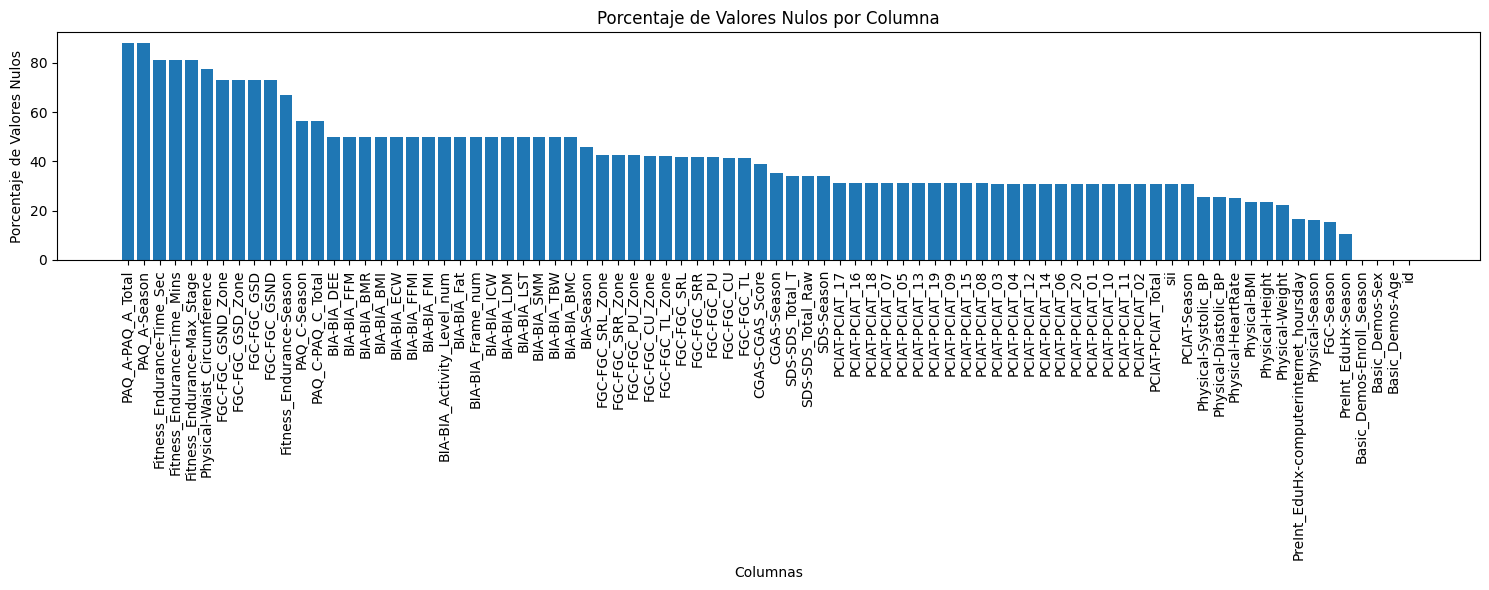


--- Resumen de Limpieza de Datos ---
Número total de columnas original: 82
Número de columnas eliminadas: 13
Número de columnas conservadas: 69
Nuevo shape del DataFrame: (3960, 69)

--- Columnas Eliminadas ---
Columna | % de Valores Nulos
------------------------------
PAQ_A-PAQ_A_Total: 88.01%
PAQ_A-Season: 88.01%
Fitness_Endurance-Time_Sec: 81.31%
Fitness_Endurance-Time_Mins: 81.31%
Fitness_Endurance-Max_Stage: 81.24%
Physical-Waist_Circumference: 77.32%
FGC-FGC_GSND_Zone: 73.18%
FGC-FGC_GSD_Zone: 73.16%
FGC-FGC_GSD: 72.88%
FGC-FGC_GSND: 72.88%
Fitness_Endurance-Season: 66.97%
PAQ_C-Season: 56.54%
PAQ_C-PAQ_C_Total: 56.54%

--- Columnas Conservadas ---
Columna | % de Valores Nulos
------------------------------
id: 0.00%
Basic_Demos-Enroll_Season: 0.00%
Basic_Demos-Age: 0.00%
Basic_Demos-Sex: 0.00%
CGAS-Season: 35.48%
CGAS-CGAS_Score: 38.86%
Physical-Season: 16.41%
Physical-BMI: 23.69%
Physical-Height: 23.56%
Physical-Weight: 22.32%
Physical-Diastolic_BP: 25.40%
Physical-HeartRate:

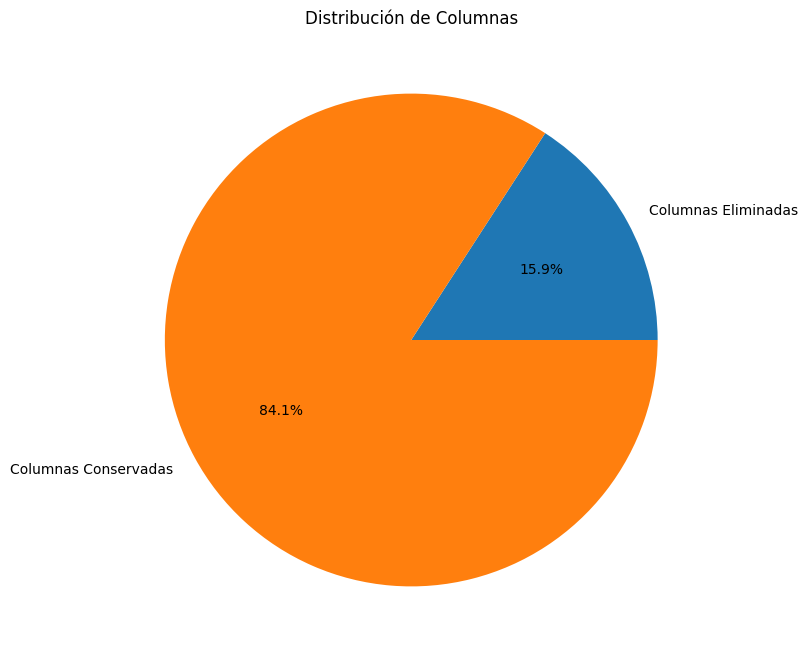

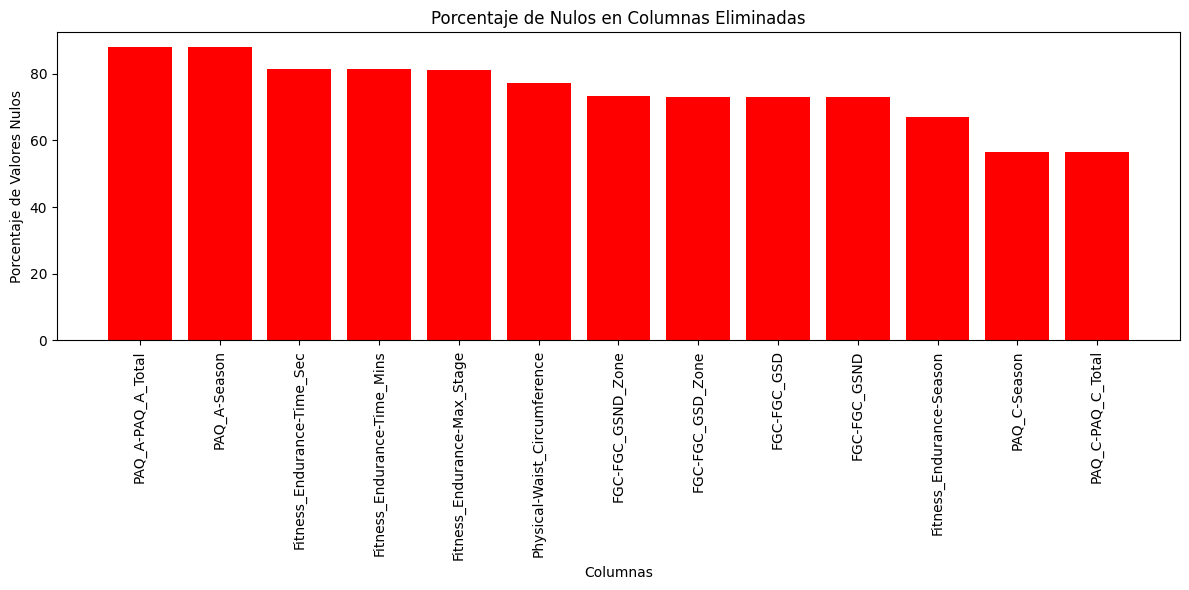

In [ ]:
# Cálculo del porcentaje de valores nulos
null_percentage = df_train.isnull().sum() * 100 / len(df_train)

# Crear un DataFrame con la información de nulos
null_info = pd.DataFrame({
    'Column': null_percentage.index,
    'Null Percentage': null_percentage.values
})

# Ordenar por porcentaje de nulos de mayor a menor
null_info = null_info.sort_values('Null Percentage', ascending=False)

# Identificar columnas a eliminar
columns_to_drop = null_info[null_info['Null Percentage'] > 50]['Column'].tolist()
columns_to_keep = [col for col in df_train.columns if col not in columns_to_drop]

# Visualización del porcentaje de nulos
plt.figure(figsize=(15, 6))
plt.bar(null_info['Column'], null_info['Null Percentage'])
plt.title('Porcentaje de Valores Nulos por Columna')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Nulos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Eliminación de columnas
df_train_cleaned = df_train.drop(columns=columns_to_drop)

# Impresión de resultados detallados
print("\n--- Resumen de Limpieza de Datos ---")
print(f"Número total de columnas original: {len(df_train.columns)}")
print(f"Número de columnas eliminadas: {len(columns_to_drop)}")
print(f"Número de columnas conservadas: {len(columns_to_keep)}")
print(f"Nuevo shape del DataFrame: {df_train_cleaned.shape}")

# Sección de columnas eliminadas
print("\n--- Columnas Eliminadas ---")
print("Columna | % de Valores Nulos")
print("-" * 30)
for col in columns_to_drop:
    percentage = null_percentage[col]
    print(f"{col}: {percentage:.2f}%")

# Sección de columnas conservadas
print("\n--- Columnas Conservadas ---")
print("Columna | % de Valores Nulos")
print("-" * 30)
for col in columns_to_keep:
    percentage = null_percentage[col]
    print(f"{col}: {percentage:.2f}%")

# Gráfico de distribución de columnas
plt.figure(figsize=(8, 8))
plt.pie(
    [len(columns_to_drop), len(columns_to_keep)],
    labels=['Columnas Eliminadas', 'Columnas Conservadas'],
    autopct='%1.1f%%'
)
plt.title('Distribución de Columnas')
plt.show()

# Gráfico de barras comparativo
plt.figure(figsize=(12, 6))
eliminated = null_info[null_info['Null Percentage'] > 50]
plt.bar(eliminated['Column'], eliminated['Null Percentage'], color='red', label='Columnas Eliminadas')
plt.title('Porcentaje de Nulos en Columnas Eliminadas')
plt.xlabel('Columnas')
plt.ylabel('Porcentaje de Valores Nulos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

df_train = df_train[columns_to_keep]

In [ ]:
# Eliminar filas con datos nulos
countCollumns = len(df_train)
df_train.dropna(how='all', inplace=True)

# Describir el efecto de la eliminación
print("Número de filas antes de eliminar datos nulos:", countCollumns)
print("Número de filas después de eliminar datos nulos:", len(df_train))
print("Número de filas eliminadas:", len(df_train) - countCollumns)

Número de filas antes de eliminar datos nulos: 3960
Número de filas después de eliminar datos nulos: 3960
Número de filas eliminadas: 0


##Explorando la distribución de la variable objetivo (sii)


In [ ]:
unique_sii_values = df_train['sii'].unique()
unique_sii_values

array([ 2.,  0.,  1., nan,  3.])

In [ ]:
# Define the mapping for `sii` levels including "Missing" for NaNs
sii_Map = {
    0: "None",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    "Missing": "Missing Data"
}

# Replace NaN values with "missing" to count them as a separate category
df_train['sii_filled'] = df_train['sii'].fillna("Missing")
df_train['sii_target'] = df_train['sii_filled'].map(sii_Map)

# Count the occurrences for each `sii` level, including missing data
sii_Counts = df_train['sii_target'].value_counts()
sii_Percentages = (sii_Counts / sii_Counts.sum()) * 100

# Create DataFrame for plotting with counts and percentages, placing "Missing Data" at the end
sii_data = pd.DataFrame({
    'SII_Level': sii_Counts.index,
    'Count': sii_Counts.values,
    'Percentage': sii_Percentages.values
})

# Reorder to ensure "Missing Data" is at the end
sii_data['SII_Level'] = pd.Categorical(sii_data['SII_Level'], categories=["None", "Mild", "Moderate", "Severe", "Missing Data"], ordered=True)
sii_data = sii_data.sort_values('SII_Level')

# Define color mapping based on sii levels
colors = {
    "None": "#4B9CD3",        # Blue
    "Mild": "#0074D9",        # Darker Blue
    "Moderate": "#17BECF",    # Teal
    "Severe": "#FF4136",      # Red
    "Missing Data": "#A9A9A9" # Gray
}

# Plot the data in Plotly and apply the colors based on SII Level
fig = px.bar(
    sii_data,
    x='SII_Level',
    y='Count',
    text='Count',
    title="Distribución de la variable objetivo del SII",
    labels={'Count': 'Number of Participants', 'SII Level': 'SII Severity Level'},
    hover_data={'Percentage': ':.2f'}
)

# Apply custom colors to each bar based on SII Level
fig.update_traces(marker=dict(color=[colors[level] for level in sii_data['SII_Level']]))

# Customize the layout to match the previous settings
fig.update_layout(
    title_font=dict(size=20, color="#004080"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    margin=dict(t=100, l=50, r=50, b=80)
)

fig.show()

In [ ]:
print(df_data_dictionary[
df_data_dictionary['Field'].str.contains('PCIAT-PCIAT_Total')
]["Value Labels"].iloc[0])

Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe


In [ ]:
# Create a KDE plot of PCIAT-PCIAT_Total
fig_kde = px.histogram(
    df_train,
    x="PCIAT-PCIAT_Total",
    nbins=50,
    opacity=0.7,
    histnorm="density",
    marginal="violin",
    title="Density Plot of PCIAT-PCIAT_Total",
    labels={"PCIAT-PCIAT_Total": "PCIAT-PCIAT_Total Score", "density": "Density"}
)

# Customize layout for consistency with previous styling
fig_kde.update_layout(
    title_font=dict(size=20, color="#004080"),  # Title color and size
    plot_bgcolor='white',                      # White background
    xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    margin=dict(t=80, l=50, r=50, b=50)
)

fig_kde.show()

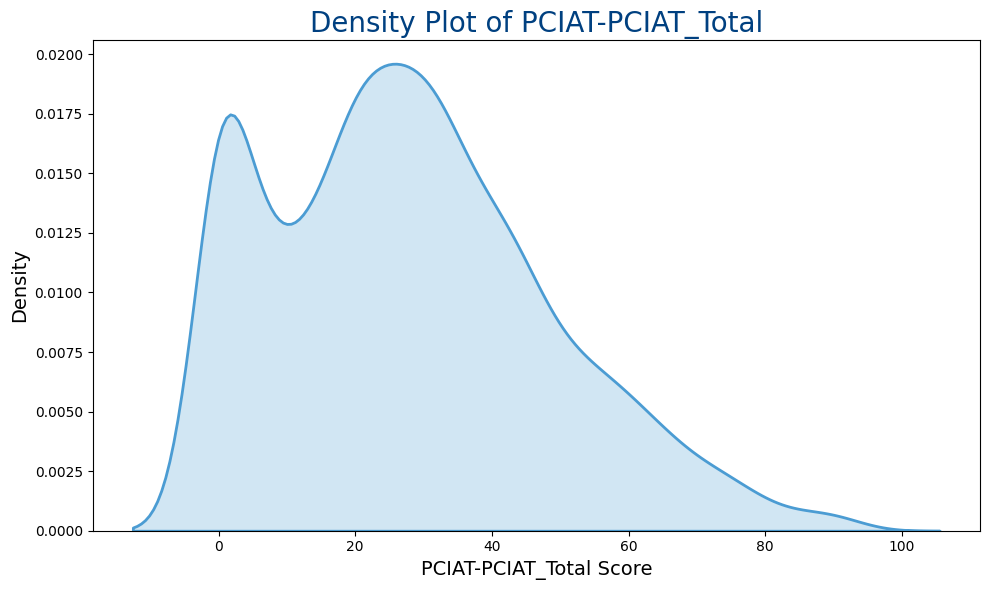

In [ ]:
# Set up the figure and plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_train,
    x="PCIAT-PCIAT_Total",
    fill=True,
    color="#4B9CD3",  # Consistent blue color
    linewidth=2
)

# Customize the plot
plt.title("Density Plot of PCIAT-PCIAT_Total", fontsize=20, color="#004080")
plt.xlabel("PCIAT-PCIAT_Total Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.tight_layout()

plt.show()

##Distribución de género


In [ ]:
print(df_data_dictionary[
df_data_dictionary['Field'].str.contains('Basic_Demos-Sex')
]["Value Labels"].iloc[0])

0=Male, 1=Female


In [ ]:
df_train['Basic_Demos-Sex'].value_counts(dropna=False, normalize=True)

,proportion
Basic_Demos-Sex,
0,0.627273
1,0.372727


In [ ]:
# Map for the sex categories
sex_map = {0: "Male", 1: "Female"}
# Color palette - asignar colores específicos
color_palette = {
    "Male": "#4B9CD3",    # Azul claro para hombres
    "Female": "#FF69B4"   # Rosa para mujeres
}

# Apply the mapping to create a new column for visualization
df_train['Sex'] = df_train['Basic_Demos-Sex'].map(sex_map)

# Count occurrences for each category and calculate percentages
sex_counts = df_train['Sex'].value_counts().sort_index()
sex_percentages = (sex_counts / sex_counts.sum()) * 100

# Create a DataFrame for plotting
sex_data = pd.DataFrame({
    'Sex': sex_counts.index,
    'Count': sex_counts.values,
    'Percentage': sex_percentages.values
})

# Plot the data
fig = px.bar(
    sex_data,
    x='Sex',
    y='Count',
    title="Distribución del sexo de los participantes",
    labels={'Count': 'Number of Participants', 'Sex': 'Sex'},
    hover_data={'Percentage': ':.2f'}
)

# Use the same blue color for both categories
fig.update_traces(marker_color="#4B9CD3", marker_line_width=0)  # Blue color for both Male and Female
fig.update_layout(
    title_font=dict(size=20, color="#004080"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    margin=dict(t=80, l=50, r=50, b=80)
)

fig.show()

##Distribución de etapas de edades


In [ ]:
print(df_data_dictionary[
df_data_dictionary['Field'].str.contains('Basic_Demos-Age')
]["Value Labels"].iloc[0])

nan


In [ ]:
df_train['Basic_Demos-Age'].value_counts(dropna=False, normalize=True).sort_index()

,proportion
Basic_Demos-Age,
5,0.028283
6,0.093182
7,0.110101
8,0.123737
9,0.117929
10,0.106061
11,0.084343
12,0.073485
13,0.059596


El ciclo vital puede dividirse en diferentes etapas del desarrollo, aunque no deben tomarse en forma absoluta y recordar que existe diversidad individual y cultural. La siguiente clasificación es un ejemplo: in utero y nacimiento, primera infancia (0-5 años), infancia (6 - 11 años), adolescencia (12-17 años), juventud (18 - 26 años), adultez (27 - 59 años) y vejez (60 años y más).

In [ ]:


# Assuming df_train is already loaded as in your provided code

# Define age ranges and labels
age_ranges = [
    (0, 5, "Early childhood"),
    (6, 11, "Childhood"),
    (12, 17, "Adolescence"),
    (18, 26, "Youth"),
    (27, 59, "Adulthood"),
    (60, 200, "Old age")
]

# Create the age group column
df_train['Age_Group'] = pd.cut(df_train['Basic_Demos-Age'],
                             bins=[age[0] for age in age_ranges] + [age_ranges[-1][1] +1],
                             labels=[age[2] for age in age_ranges],
                             right=True, include_lowest=True)

# Define a color map for the age groups
color_map = {
    "Early childhood": "#4B9CD3",
    "Childhood": "#0074D9",
    "Adolescence": "#17BECF",
    "Youth": "#FF4136",
    "Adulthood": "#A9A9A9",
    "Old age": "#FFD700"
}

# Create the age distribution plot using Plotly Express
fig = px.histogram(
    df_train,
    x='Age_Group',
    color='Age_Group',
    color_discrete_map=color_map,
    title="Distribución de las edades de los participantes",
    labels={'Age_Group': 'Grupo de Edad', 'count': 'Número de participantes'}
)

# Update layout for better visualization
fig.update_layout(
    title_font=dict(size=20, color="#004080"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    margin=dict(t=100, l=50, r=50, b=80)
)
fig.show()

##Información sobre los hábitos de Internet de los jóvenes basada en los comentarios de los padres


In [ ]:
# Extract columns that match "PCIAT-PCIAT_" followed by a number (not including "PCIAT-PCIAT_Total")
pciat_columns = [col for col in df_train.columns if col.startswith('PCIAT-PCIAT_') and col != 'PCIAT-PCIAT_Total']

# Check for NaN values in each of these columns
nan_counts = df_train[pciat_columns].isna().sum()

# Filter to show only columns with missing values
missing_values = nan_counts[nan_counts > 0]

# Display the results
print("Columnas con valores NaN en campos PCIAT-PCIAT_:")
print(missing_values)

Columnas con valores NaN en campos PCIAT-PCIAT_:
PCIAT-PCIAT_01    1227
PCIAT-PCIAT_02    1226
PCIAT-PCIAT_03    1229
PCIAT-PCIAT_04    1229
PCIAT-PCIAT_05    1231
PCIAT-PCIAT_06    1228
PCIAT-PCIAT_07    1231
PCIAT-PCIAT_08    1230
PCIAT-PCIAT_09    1230
PCIAT-PCIAT_10    1227
PCIAT-PCIAT_11    1226
PCIAT-PCIAT_12    1229
PCIAT-PCIAT_13    1231
PCIAT-PCIAT_14    1228
PCIAT-PCIAT_15    1230
PCIAT-PCIAT_16    1232
PCIAT-PCIAT_17    1235
PCIAT-PCIAT_18    1232
PCIAT-PCIAT_19    1230
PCIAT-PCIAT_20    1227
dtype: int64


In [ ]:
# Filter for PCIAT-related fields in the data dictionary
pciat_dict_df = df_data_dictionary[df_data_dictionary['Field'].str.startswith('PCIAT-PCIAT_')]

# Create the map from field names to short descriptions
pciat_question_map = dict(zip(pciat_dict_df['Field'], pciat_dict_df['Description']))


# Define the explanation for each response category, including "Missing" at the beginning
scale_explanation = {
    "missing": "Missing",
    0: "Does Not Apply",
    1: "Rarely",
    2: "Occasionally",
    3: "Frequently",
    4: "Often",
    5: "Always"
}

# Define a function to insert line breaks based on character limit
def wrap_text(text, char_limit=25, padding_lines=0):
    words = text.split()
    wrapped_text = ""
    line = ""
    for word in words:
        if len(line) + len(word) + 1 > char_limit:
            wrapped_text += line + "<br>"
            line = word
        else:
            line += (" " if line else "") + word
    wrapped_text += line
    # Add extra line breaks for padding
    wrapped_text += "<br>" * padding_lines
    return wrapped_text

# Wrap long titles to fit within specified width and add padding
subplot_titles = [wrap_text(pciat_question_map[col], char_limit=25, padding_lines=0) for col in pciat_columns]

# Set the number of columns to 2 for better readability
num_cols = 2
num_rows = (len(pciat_columns) + num_cols - 1) // num_cols  # Calculate rows needed

# Colors based on the Child Mind Institute logo
bar_color = "#0082c8"  # Blue color for bars
missing_color = "#A9A9A9"  # Gray color for "Missing" category
title_color = "#004080"  # Darker blue shade for titles

# Create subplot grid with wrapped titles and minimal spacing
fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=subplot_titles)

# Add a bar plot for each PCIAT question
for i, col in enumerate(pciat_columns):
    row = i // num_cols + 1
    col_pos = i % num_cols + 1

    # Count the responses, including NaN as "Missing"
    response_counts = df_train[col].value_counts().sort_index()
    missing_count = df_train[col].isna().sum()

    # Create a DataFrame for plotting with the missing count added at the start
    response_data = pd.DataFrame({
        'Response': ['Missing'] + response_counts.index.map(scale_explanation).tolist(),
        'Count': [missing_count] + response_counts.values.tolist()
    })
    response_data['Percentage'] = (response_data['Count'] / response_data['Count'].sum()) * 100

    # Create a bar plot for the current question with percentages in the hover
    bar_fig = px.bar(response_data, x='Response', y='Count',
                     labels={'Count': 'Frequency', 'Response': 'Response'},
                     hover_data={'Percentage': ':.2f'},
                     title=pciat_question_map[col])

    # Customize each bar plot's appearance, setting a different color for "Missing"
    colors = [missing_color if x == "Missing" else bar_color for x in response_data['Response']]
    bar_fig.update_traces(marker_color=colors)  # Apply custom colors
    bar_fig.update_layout(
        showlegend=False,  # Hide legend
        xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=10, color=title_color)),  # Smaller x-axis labels with blue color
        yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=10))  # Remove y-axis grid and lines
    )

    # Add the bar plot to the grid
    for trace in bar_fig.data:
        fig.add_trace(trace, row=row, col=col_pos)

# Update layout for readability, spacing, and background color
fig.update_layout(
    height=300 * num_rows,  # Set a fixed height per row
    width=1000,  # Increase width slightly to give more space
    title_text="Distribución de respuestas a las preguntas de la prueba sobre adicción a Internet entre padres e hijos",
    title_font=dict(size=20, color=title_color),  # Set main title font size
    margin=dict(t=140, l=50, r=50, b=100),  # Increase top margin
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Rotate x-axis labels slightly
fig.update_xaxes(tickangle=15)
fig.update_yaxes(tickfont=dict(size=10))

# Set font size for subplot titles
fig.update_annotations(font=dict(size=12, color=title_color))  # Adjust subplot title font size and color

fig.show()

##Uso diario de Internet


In [ ]:
print(df_data_dictionary[
df_data_dictionary['Field'].str.contains('PreInt_EduHx-computerinternet_hoursday')
]["Value Labels"].iloc[0])

0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day


In [ ]:
df_train["PreInt_EduHx-computerinternet_hoursday"].value_counts(dropna=False, normalize=True).sort_index()


,proportion
PreInt_EduHx-computerinternet_hoursday,
0.0,0.384848
1.0,0.104293
2.0,0.253535
3.0,0.090909
NaN,0.166414


In [ ]:
# Define the mapping for hours per day categories with a label for missing values
internet_hours_map = {
    0: "Less than 1h/day",
    1: "Around 1h/day",
    2: "Around 2hs/day",
    3: "More than 3hs/day",
    "missing": "Missing Data"
}

# Replace NaN values with "missing" to count them as a separate category
df_train['Internet_Use_Hours'] = df_train['PreInt_EduHx-computerinternet_hoursday'].map(
    lambda x: internet_hours_map.get(x, "Missing Data")
)

# Convert 'Internet_Use_Hours' to a categorical type with the specified order
category_order = list(internet_hours_map.values())
df_train['Internet_Use_Hours'] = pd.Categorical(df_train['Internet_Use_Hours'], categories=category_order, ordered=True)

# Count occurrences of each category (including "Missing Data") and calculate percentages
internet_use_counts = df_train['Internet_Use_Hours'].value_counts(sort=False)
internet_use_percentages = (internet_use_counts / internet_use_counts.sum()) * 100

# Create DataFrame for plotting
internet_use_data = pd.DataFrame({
    'Hours per Day': internet_use_counts.index,
    'Count': internet_use_counts.values,
    'Percentage': internet_use_percentages.values
})

# Define custom colors, using gray for "Missing Data" and blue for other categories
colors = ["#A9A9A9" if category == "Missing Data" else "#4B9CD3" for category in internet_use_data['Hours per Day']]

# Plot the data
fig = px.bar(
    internet_use_data,
    x='Hours per Day',
    y='Count',
    title="Distribución del uso diario de Internet entre los jóvenes",
    labels={'Count': 'Number of Respondents', 'Hours per Day': 'Daily Internet Usage'},
    hover_data={'Percentage': ':.2f'}
)

# Apply custom colors and layout
fig.update_traces(marker_color=colors, marker_line_width=0)
fig.update_layout(
    title_font=dict(size=20, color="#004080"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    yaxis=dict(showgrid=False, showline=False, zeroline=False, tickfont=dict(size=12)),
    margin=dict(t=80, l=50, r=50, b=80)
)

fig.show()

##Analysis of Continuous Variables by SII Target Distribution

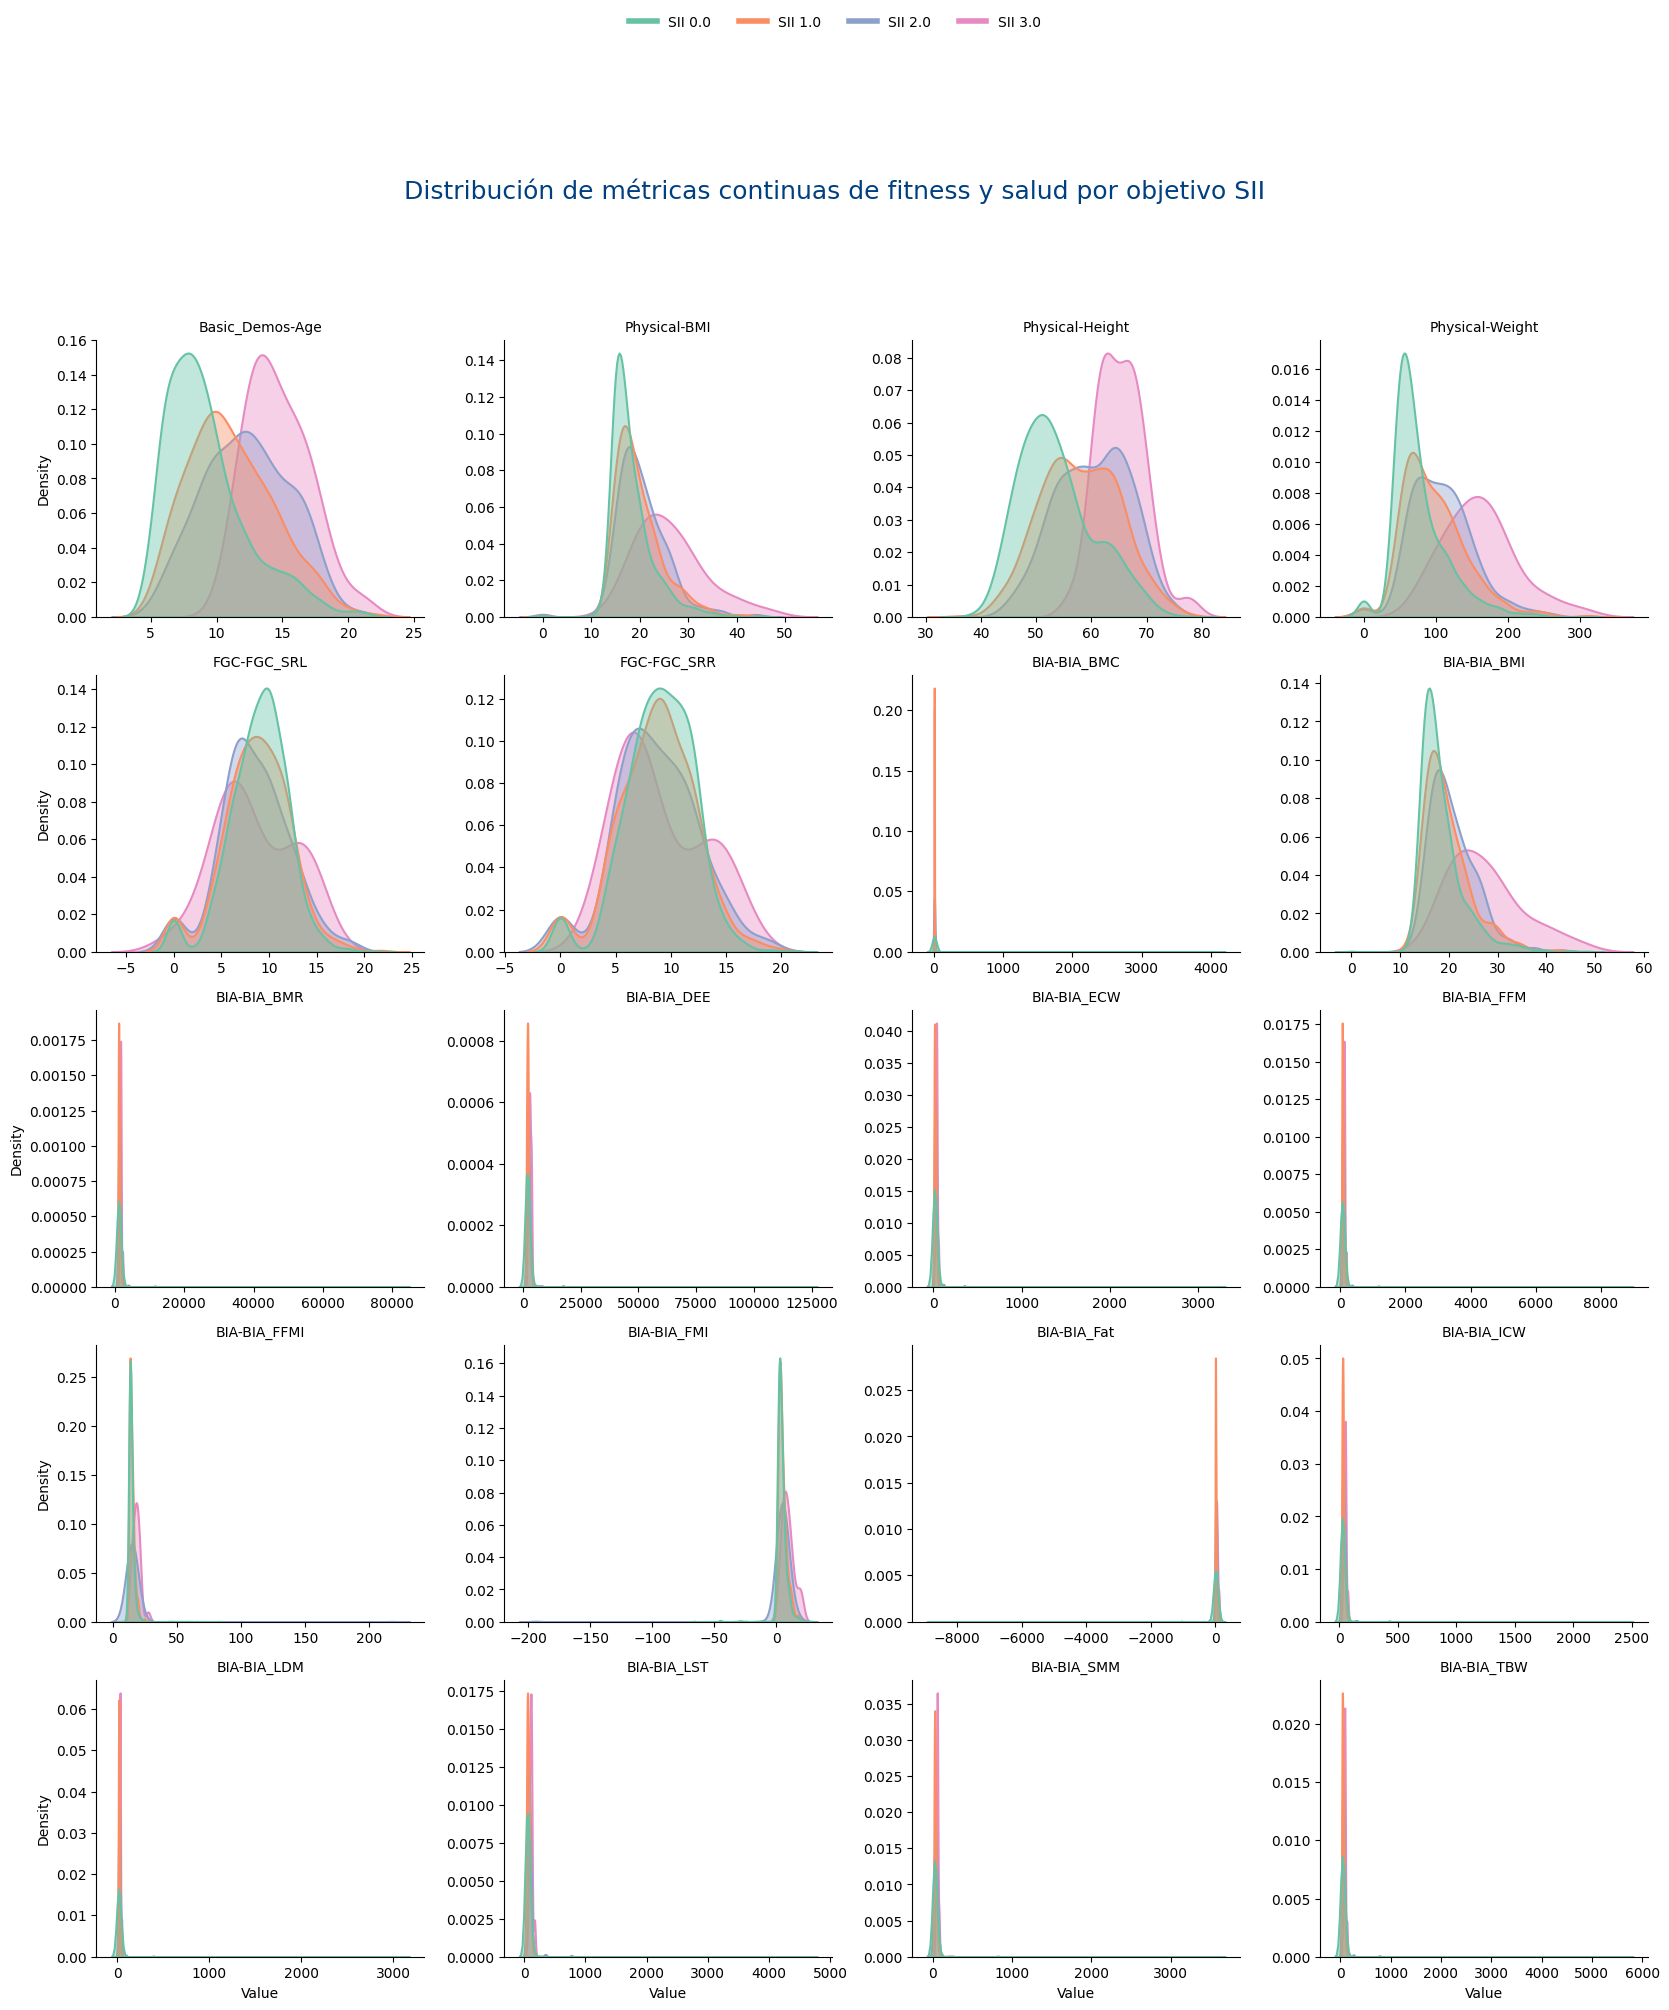

In [ ]:
# List of continuous columns based on your data
continuous_columns = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'FGC-FGC_SRL', 'FGC-FGC_SRR',
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
    'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
    'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
    'BIA-BIA_SMM', 'BIA-BIA_TBW'
]

# Select only the continuous columns and the sii target
data_continuous = df_train[continuous_columns + ['sii']]

# Remove rows where sii is NaN, but keep NaNs in continuous variables
data_continuous = data_continuous.dropna(subset=['sii'])

# Melt the data to long format for Seaborn
data_long = pd.melt(data_continuous, id_vars='sii', var_name="variable", value_name="value")

# Set up the FacetGrid for KDE plots with increased figure size
g = sns.FacetGrid(data_long, col="variable", col_wrap=4, height=3.5, aspect=1.2, sharex=False, sharey=False)

# Map KDE plots onto the grid, using hue for sii target
g.map_dataframe(sns.kdeplot, x="value", hue="sii", fill=True, common_norm=False, palette="Set2", alpha=0.4, linewidth=1.5)

# Add title, adjust layout
g.fig.suptitle("Distribución de métricas continuas de fitness y salud por objetivo SII", y=1.05, fontsize=18, color="#004080")
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Density")

# Create custom legend
# Define the labels and colors (matching `palette="Set2"` used above)
sii_labels = sorted(data_continuous['sii'].dropna().unique())
colors = sns.color_palette("Set2", len(sii_labels))
legend_elements = [Line2D([0], [0], color=color, lw=4, label=f'SII {label}') for color, label in zip(colors, sii_labels)]

# Position the custom legend outside of the grid
g.fig.legend(handles=legend_elements, loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False)

plt.tight_layout()
plt.show()

##Mapa de calor de correlación entre variables continuas y sii

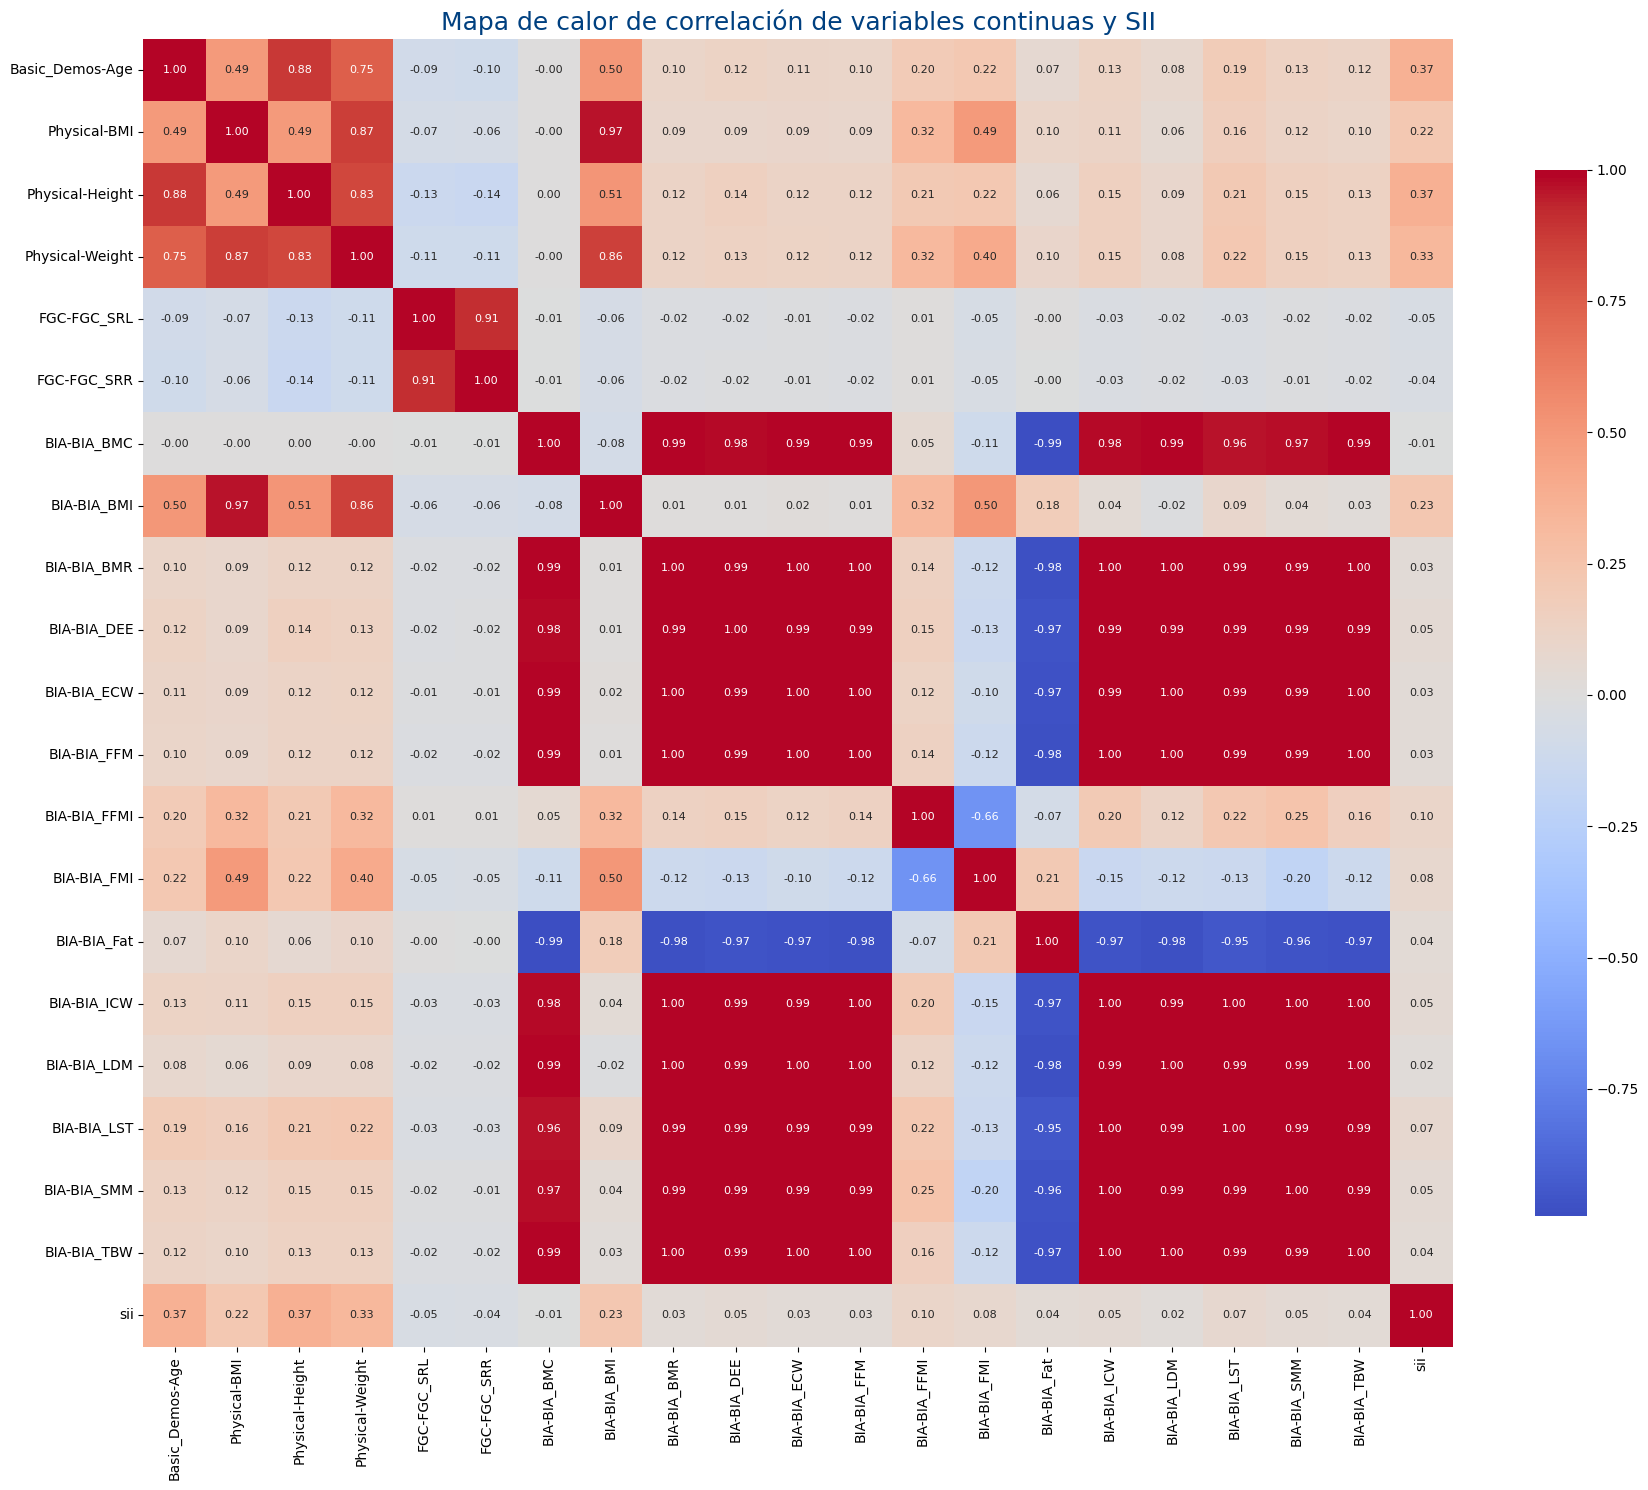

In [ ]:
# Calculate the correlation matrix
continuous_columns = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'FGC-FGC_SRL', 'FGC-FGC_SRR',
    'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
    'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI',
    'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
    'BIA-BIA_SMM', 'BIA-BIA_TBW', 'sii'
]

correlation_matrix = df_train[continuous_columns].corr()

# Plot the heatmap with improved readability
plt.figure(figsize=(18, 15))  # Increase figure size
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",  # Reduce the number of decimal places
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 8},  # Set annotation font size smaller
    cbar_kws={"shrink": 0.8}  # Shrink color bar slightly
)

# Adjust the labels for readability
plt.xticks(rotation=90, fontsize=10)  # Rotate x labels for better fit
plt.yticks(rotation=0, fontsize=10)   # Keep y labels horizontal
plt.title("Mapa de calor de correlación de variables continuas y SII", fontsize=18, color="#004080")
plt.tight_layout()  # Ensure everything fits within the figure area

plt.show()

##Estadística Descriptiva de Variables Categoricas

In [ ]:
# List of integer variables to analyze
integer_columns = list(df_data_dictionary[
    df_data_dictionary['Type'].str.contains('int') & ~df_data_dictionary['Type'].str.contains('categorical')
]["Field"].unique())

# Filter integer_columns to only include columns present in df_train
integer_columns = [col for col in integer_columns if col in df_train.columns]

# Calculate the statistics for each column
column_stats = {
    col: {
        'Null Percentage': df_train[col].isna().mean() * 100,
        'Unique Values': df_train[col].nunique(),
        'Mean': df_train[col].mean(),
        'Std': df_train[col].std(),
        'Min': df_train[col].min(),
        '25%': df_train[col].quantile(0.25),
        '50%': df_train[col].median(),
        '75%': df_train[col].quantile(0.75),
        'Max': df_train[col].max()
    }
    for col in integer_columns
}

# Create a DataFrame to display the results
stats_df = pd.DataFrame.from_dict(column_stats, orient='index').reset_index()
stats_df.columns = [
    'Column', 'Null Percentage', 'Unique Values',
    'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'
]
stats_df = stats_df.sort_values(by='Null Percentage', ascending=False).reset_index(drop=True)

# Display the DataFrame
stats_df

,Column,Null Percentage,Unique Values,Mean,Std,Min,25%,50%,75%,Max
0,FGC-FGC_PU,41.666667,44,5.579654,7.390161,0.0,0.0,3.0,9.00,51.0
1,FGC-FGC_CU,41.363636,59,11.259690,11.807781,0.0,3.0,9.0,15.75,115.0
2,FGC-FGC_TL,41.313131,43,9.252775,2.988863,0.0,7.0,10.0,12.00,22.0
3,CGAS-CGAS_Score,38.863636,59,65.454771,22.341862,25.0,59.0,65.0,75.00,999.0
4,SDS-SDS_Total_T,34.191919,49,57.763622,13.196091,38.0,47.0,55.0,64.00,100.0
5,SDS-SDS_Total_Raw,34.116162,62,41.088923,10.427433,17.0,33.0,39.0,46.00,96.0
6,PCIAT-PCIAT_Total,30.909091,93,27.896199,20.338853,0.0,12.0,26.0,41.00,93.0
7,Physical-Diastolic_BP,25.404040,102,69.648951,13.611226,0.0,61.0,68.0,76.00,179.0
8,Physical-Systolic_BP,25.404040,129,116.983074,17.061225,0.0,107.0,114.0,125.00,203.0
9,Physical-HeartRate,25.075758,88,81.597236,13.665196,27.0,72.0,81.0,90.50,138.0


In [ ]:
# Get unique values from the 'Column' column
unique_column_values = stats_df['Column'].unique()

# Print the unique values
unique_column_values


array(['FGC-FGC_PU', 'FGC-FGC_CU', 'FGC-FGC_TL', 'CGAS-CGAS_Score',
       'SDS-SDS_Total_T', 'SDS-SDS_Total_Raw', 'PCIAT-PCIAT_Total',
       'Physical-Diastolic_BP', 'Physical-Systolic_BP',
       'Physical-HeartRate'], dtype=object)

In [ ]:
for index, row in stats_df.iterrows():
    column_name = row['Column']
    try:
        value_label = df_data_dictionary[
            df_data_dictionary['Field'].str.contains(column_name)
        ]["Value Labels"].iloc[0]
        value_decription = df_data_dictionary[
            df_data_dictionary['Field'].str.contains(column_name)
        ]["Description"].iloc[0]
        print(f"Column: {column_name}, Value Labels: {value_label}, Description: {value_decription}")
    except IndexError:
        print(f"Column: {column_name}, Value Labels: Not Found")

Column: FGC-FGC_PU, Value Labels: nan, Description: Push-up total
Column: FGC-FGC_CU, Value Labels: nan, Description: Curl up total
Column: FGC-FGC_TL, Value Labels: nan, Description: Trunk lift total
Column: CGAS-CGAS_Score, Value Labels: nan, Description: Children's Global Assessment Scale Score
Column: SDS-SDS_Total_T, Value Labels: nan, Description: Total T-Score
Column: SDS-SDS_Total_Raw, Value Labels: nan, Description: Total Raw Score
Column: PCIAT-PCIAT_Total, Value Labels: Severity Impairment Index: 0-30=None; 31-49=Mild; 50-79=Moderate; 80-100=Severe, Description: Total Score
Column: Physical-Diastolic_BP, Value Labels: nan, Description: Diastolic BP (mmHg)
Column: Physical-Systolic_BP, Value Labels: nan, Description: Systolic BP (mmHg)
Column: Physical-HeartRate, Value Labels: nan, Description: Heart rate (beats/min)


In [ ]:
df_train.columns


Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
       'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_1

In [ ]:
# Si las columnas existen en el DataFrame
if {'sii', 'sii_filled', 'sii_target'}.issubset(df_train.columns):
  # Get unique values for the specified columns
  unique_sii = df_train['sii'].unique()
  unique_sii_filled = df_train['sii_filled'].unique()
  unique_sii_target = df_train['sii_target'].unique()
  print("Valores de 'sii' :\n", unique_sii)
  print("\nValores en 'sii_filled':\n", unique_sii_filled)
  print("\nValores en 'sii_target' :\n", unique_sii_target)
else:
  print("Una o más columnas especificadas no existen en el DataFrame. Verifique los nombres de las columnas.")


Valores de 'sii' :
 [ 2.  0.  1. nan  3.]

Valores en 'sii_filled':
 [2.0 0.0 1.0 'Missing' 3.0]

Valores en 'sii_target' :
 ['Moderate' 'None' 'Mild' 'Missing Data' 'Severe']


In [ ]:
columns_to_remove = ['id','sii_target', 'sii_filled', 'Sex', 'Age_Group']

# Check if the columns exist in the dataframe before attempting to drop them
columns_to_drop = [col for col in columns_to_remove if col in df_train.columns]
if columns_to_drop:
    df_train = df_train.drop(columns=columns_to_drop)
    print(f"Columns {columns_to_drop} removed successfully.")
else:
    print(f"None of the specified columns were found in the DataFrame.")


Columns ['id', 'sii_target', 'sii_filled', 'Sex', 'Age_Group'] removed successfully.


In [ ]:
# Remove rows where 'sii' is NaN
df_train = df_train.dropna(subset=['sii'])

In [ ]:
# Columns to remove
columns_to_remove = ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
       'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
       'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
       'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'FGC-Season', 'BIA-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'Internet_Use_Hours','SDS-SDS_Total_Raw']

# Check if the columns exist before attempting to drop them
columns_to_drop = [col for col in columns_to_remove if col in df_train.columns]

if columns_to_drop:
    df_train = df_train.drop(columns=columns_to_drop)
    print(f"Columns {columns_to_drop} removed successfully.")
else:
    print("None of the specified columns were found in the DataFrame.")

# ... (rest of your existing code)

Columns ['PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'FGC-Season', 'BIA-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season', 'Internet_Use_Hours', 'SDS-SDS_Total_Raw'] removed successfully.


In [ ]:
from pycaret.regression import *
from pycaret.classification import *


clf = setup(data=df_train, target='sii', session_id=123 )

best_model=compare_models(cross_validation=True, sort='AUC', verbose=True)

# evaluate trained model
evaluate_model(best_model)

# Entrenar y afinar el mejor modelo
print(best_model)



,Description,Value
0,Session id,123
1,Target,sii
2,Target type,Multiclass
3,Original data shape,"(2736, 38)"
4,Transformed data shape,"(2736, 38)"
5,Transformed train set shape,"(1915, 38)"
6,Transformed test set shape,"(821, 38)"
7,Numeric features,37
8,Rows with missing values,58.7%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5869,0.6910,0.5869,0.5284,0.5367,0.1695,0.1836,0.7720
lightgbm,Light Gradient Boosting Machine,0.5754,0.6818,0.5754,0.5246,0.5413,0.1809,0.1871,4.1540
et,Extra Trees Classifier,0.5812,0.6787,0.5812,0.5065,0.5259,0.1521,0.1658,0.5770
xgboost,Extreme Gradient Boosting,0.5707,0.6735,0.5707,0.5259,0.5386,0.1748,0.1810,0.9180
knn,K Neighbors Classifier,0.5650,0.6113,0.5650,0.4955,0.5081,0.1103,0.1223,0.0610
nb,Naive Bayes,0.2664,0.6081,0.2664,0.1351,0.1510,0.0105,0.0065,0.0460
dt,Decision Tree Classifier,0.4830,0.5608,0.4830,0.4918,0.4862,0.1060,0.1063,0.0820
dummy,Dummy Classifier,0.5828,0.5000,0.5828,0.3396,0.4291,0.0000,0.0000,0.0400
lr,Logistic Regression,0.5979,0.0000,0.5979,0.5420,0.5396,0.1783,0.2027,0.5840
svm,SVM - Linear Kernel,0.5216,0.0000,0.5216,0.4792,0.4485,0.1183,0.1404,0.1630


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Pull the scoring grid
results = pull()

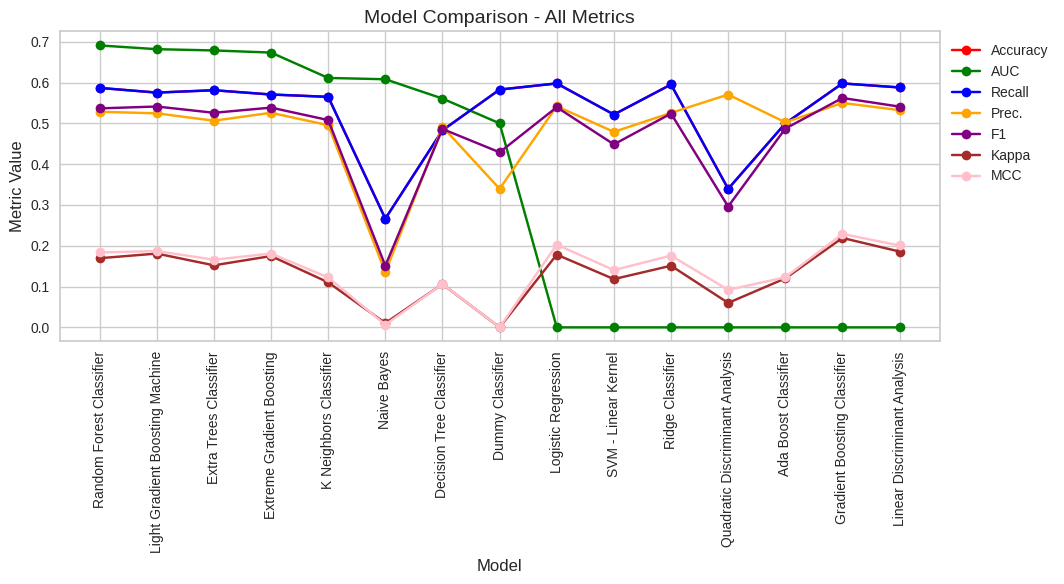

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_model_comparison(results, metrics, colors=None):
    num_models = len(results['Model'].unique())

    if colors is None:
        color_map = plt.cm.get_cmap('tab10', len(metrics))
        colors = [color_map(i) for i in range(len(metrics))]
    elif len(colors) != len(metrics):
        raise ValueError("The length of the 'colors' list must match the length of the 'metrics' list.")

    plt.figure(figsize=(12, 6))

    for i, metric in enumerate(metrics):
        plt.plot(results['Model'], results[metric], marker='o', linestyle='-', label=metric, color=colors[i])

    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.title('Model Comparison - All Metrics', fontsize=14)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

metrics = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']
custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink'] # Example colors, match the metrics
plot_model_comparison(results, metrics, custom_colors)



In [ ]:
# Crear el mejor modelo
model = create_model(best_model)
optimizado=tune_model(model, optimize='AUC', n_iter=25)



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6615,0.7509,0.6615,0.6436,0.6028,0.2979,0.3339
1,0.6094,0.7014,0.6094,0.5352,0.5546,0.2107,0.2273
2,0.5990,0.7150,0.5990,0.5526,0.5535,0.1940,0.2091
3,0.5469,0.6613,0.5469,0.4825,0.4996,0.0936,0.1003
4,0.5625,0.7166,0.5625,0.4770,0.5046,0.1149,0.1251
5,0.5602,0.6794,0.5602,0.4908,0.5160,0.1251,0.1314
6,0.5602,0.6665,0.5602,0.5023,0.5195,0.1418,0.1489
7,0.5812,0.6490,0.5812,0.5151,0.5252,0.1439,0.1589
8,0.5812,0.6871,0.5812,0.5310,0.5371,0.1647,0.1754


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6198,0.7646,0.6198,0.6353,0.5500,0.2055,0.2329
1,0.5938,0.7144,0.5938,0.4759,0.5223,0.1569,0.1754
2,0.5833,0.7238,0.5833,0.5121,0.5112,0.1160,0.1374
3,0.5781,0.6934,0.5781,0.5203,0.5050,0.1074,0.1252
4,0.6146,0.7386,0.6146,0.5096,0.5386,0.1800,0.2134
5,0.5969,0.7094,0.5969,0.5270,0.5411,0.1705,0.1874
6,0.5759,0.6903,0.5759,0.5067,0.5256,0.1485,0.1594
7,0.6073,0.6764,0.6073,0.5344,0.5356,0.1689,0.2004
8,0.6283,0.6994,0.6283,0.6077,0.5658,0.2230,0.2558


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [ ]:
print(optimizado)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_samples_leaf=6,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=220, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


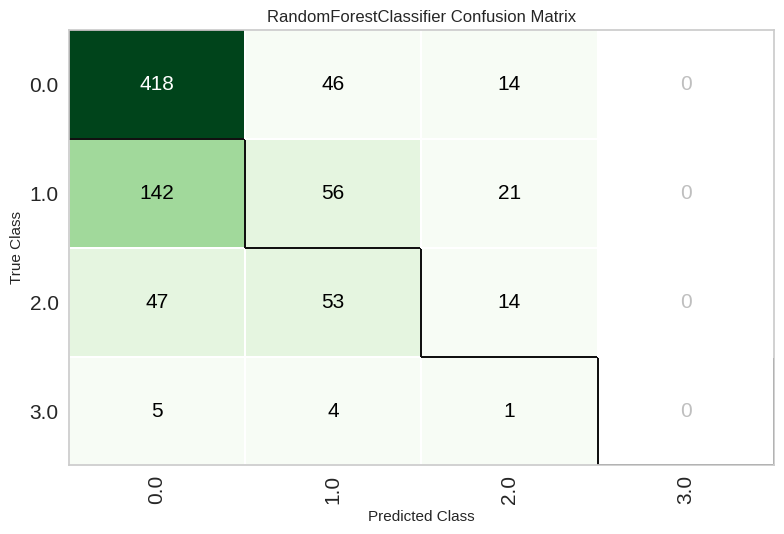

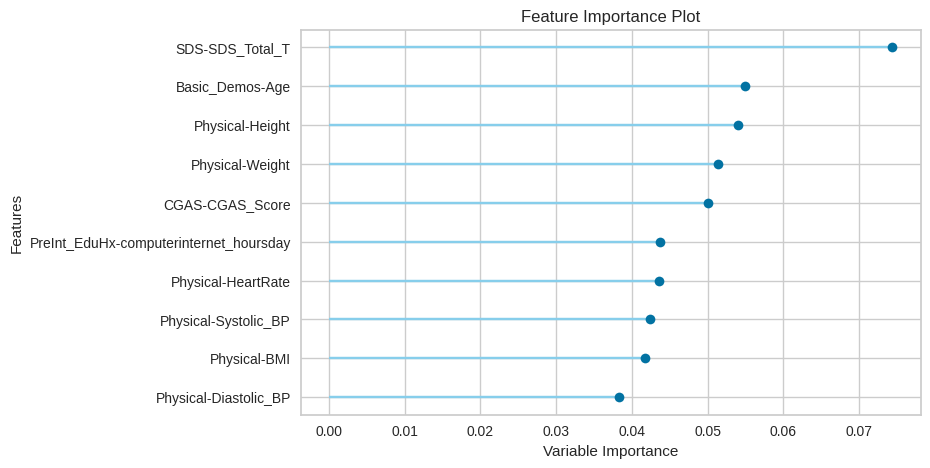

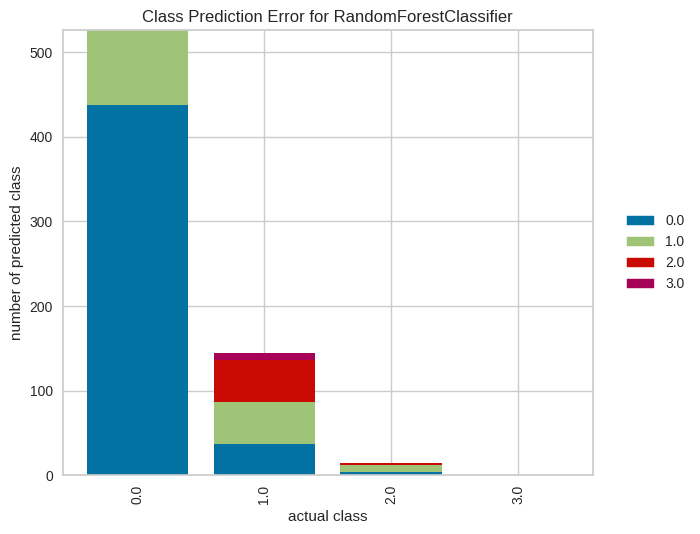

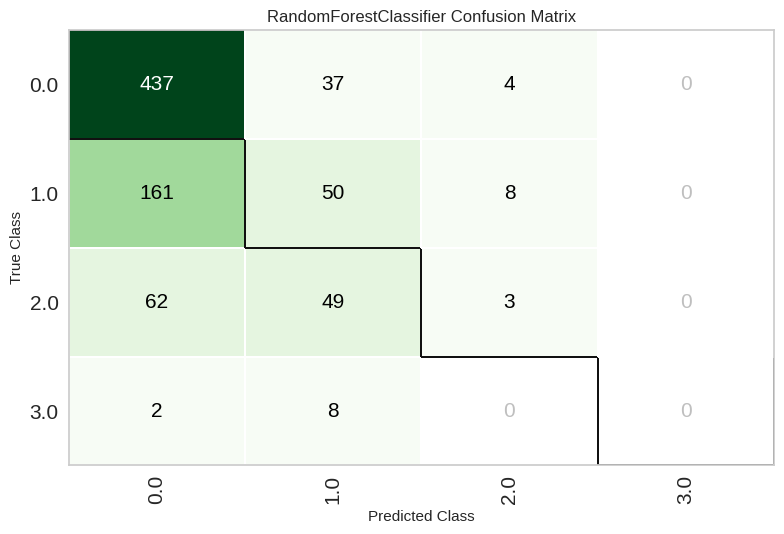

In [ ]:
# Evaluar el modelo con diferentes gráficos
plot_model(best_model, plot='confusion_matrix')
plot_model(best_model, plot='feature')
plot_model(optimizado,plot='error')
plot_model(optimizado, plot='confusion_matrix')

In [ ]:
# Predicciones en el conjunto de datos original
prediccion = predict_model(optimizado)
pd.set_option('display.max_rows', 100)
prediccion.head().T
pd.reset_option('display.max_rows')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5968,0.7300,0.5968,0.5047,0.5263,0.1622,0.1830


In [ ]:
save_model(optimizado, 'CMI_ProblematicInternetUse')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Basic_Demos-Age',
                                              'Basic_Demos-Sex',
                                              'CGAS-CGAS_Score', 'Physical-BMI',
                                              'Physical-Height',
                                              'Physical-Weight',
                                              'Physical-Diastolic_BP',
                                              'Physical-HeartRate',
                                              'Physical-Systolic_BP',
                                              'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
                                              'FGC-FGC_PU', 'FGC-FGC_PU_Zone',
                                              'FGC-FGC...
                  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                               

In [ ]:
from pycaret.regression import load_model, predict_model, plot_model
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo guardado
loaded_model = load_model('CMI_ProblematicInternetUse')  # Load the model using

# Get the training data columns
training_columns = loaded_model.named_steps['trained_model'].feature_names_in_ # Get the features used for training
#print(training_columns)

# Modify make_prediction to handle missing columns
def make_prediction(data):
    # Create a DataFrame with all training columns, filling missing values with 0
    df = pd.DataFrame([data], columns=training_columns)
    df = df.fillna(0)  # Fill NaN values with 0
    print(df.columns)

    predictions = predict_model(loaded_model, data=df)

    return predictions['prediction_label'][0]

 # Interfaz para solicitar datos al usuario y realizar la predicción
def get_user_input():
    input_data = {
        'Basic_Demos-Age': int(input("Ingresa la edad: ")),
        'Basic_Demos-Sex': input("Ingresa el sexo (male/female): "),
        'Physical-BMI': float(input("Ingresa el índice de masa corporal (BMI): ")),
        'PreInt_EduHx-computerinternet_hoursday': int(input("Ingresa el número de horas: "))
    }
    return input_data


# Ejecutar la predicción usando los datos ingresados
user_data = get_user_input()
prediction = make_prediction(user_data)
print(f'La predicción del SII es: {prediction}')

Transformation Pipeline and Model Successfully Loaded
